# Pylops - Seismic Interpolation with cupy

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import cupy as cp
import scipy as sp
import cusignal
import matplotlib.pyplot as plt

from scipy.signal import convolve

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing           import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import fista

## 2D Synthetic

In [2]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':140,
       'oy':0,'dy':2,    'ny':101,
       'ot':0,'dt':0.004,'nt':200,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.2, 0.4, 0.5]
theta_m = [0, 30, -60]
phi_m   = [0]
amp_m   = [1., -2, 0.5]

# Create axis
taxis, taxis2, xaxis, yaxis = makeaxis(par)

# Create wavelet
wav = ricker(taxis[:41], f0=par['f0'])[0]

# Generate model
m, x =  linear2d(xaxis, taxis, v, t0_m, theta_m, amp_m, wav)

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(par['nx']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# Create restriction operator
Rop = Restriction(iava=iava, dims=(par['nx'], par['nt']), axis=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

y     = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape( par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^H(Opu)=176.66573042138884 - u^H(Op^Hv)=176.66573042138887


Dot test passed, v^H(Opu)=-236.2664884276617 - u^H(Op^Hv)=-236.26648842766173
CPU times: user 2.88 s, sys: 55.1 ms, total: 2.94 s
Wall time: 196 ms


(-0.5, 139.5, 199.5, -0.5)

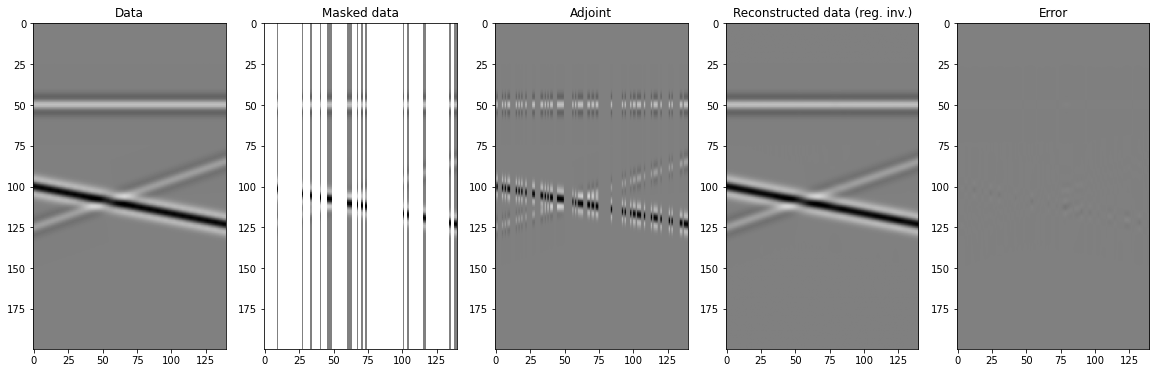

In [3]:
%%time
# Spatial smoothing with numpy
xinvf, _, _ = SeismicInterpolation(y, par['nx'], iava, kind='spatial', dottest=True,
                                   **dict(engine='pylops', epsRs=[np.sqrt(0.1)], 
                                          damp=np.sqrt(1e-4), iter_lim=200 ,show=0))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

Dot test passed, v^H(Opu)=5.675966210578785 - u^H(Op^Hv)=5.675966210578807
RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 11200 rows and 28000 cols
Regs=[<28000x28000 SecondDerivative with dtype=float64>]
epsRs=[0.31622776601683794]
-----------------------------------------------------------------
CGLS
-----------------------------------------------------------------
The Operator Op has 39200 rows and 28000 cols
damp = 1.000000e-04	tol = 1.000000e-04	niter = 200
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        0.0000e+00         1.6898e+01     1.6899e+01
     2        0.0000e+00         1.0958e+01     1.0963e+01
     3        0.0000e+00         6.8702e+00     6.8804e+00
     4        0.0000e+00         5.3506e+00     5.3651e+00
     5        0.0000e+00         4.7277e+00     4.7449e+00
     6        0.0000e+00         3.9025e+00     3.9248

(-0.5, 139.5, 199.5, -0.5)

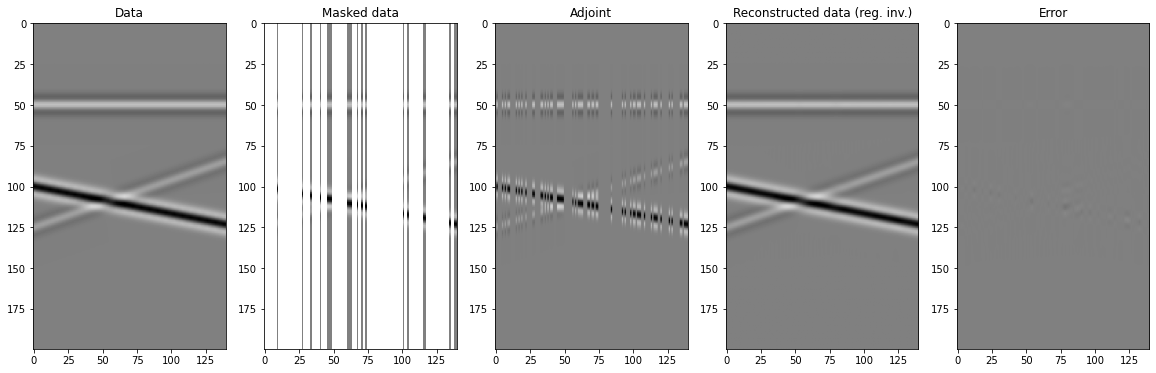

In [4]:
%%time
# Spatial smoothing with cupy
xinvf, _, _ = SeismicInterpolation(cp.array(y), par['nx'], iava, kind='spatial', dottest=True,
                                   **dict(epsRs=[np.sqrt(0.1)], damp=np.sqrt(1e-4), niter=200, show=True))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(cp.asnumpy(xinvf).T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-cp.asnumpy(xinvf).T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

In [5]:
# FK
nfft=2**10
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], sampling=[par['dx'], par['dt']])
p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft))

In [6]:
%%time
# Inverse with numpy
xinvf, pinvf, cost = SeismicInterpolation(y, par['nx'], iava, kind='fk', nffts=(nfft, nfft), 
                                          sampling=(par['dx'], par['dt']), dottest=False,
                                          **dict(niter=50, eps=1e-2, show=True))

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 11200 rows and 1048576 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 50
alpha = 1.000000e+00	thresh = 5.000000e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    3.112e+00   1.191e+02   3.080e+01
     2   -0.00e+00+0.00e+00j    2.955e+00   1.142e+02   1.590e+00
     3   -0.00e+00+0.00e+00j    2.781e+00   1.087e+02   1.896e+00
     4   -0.00e+00+0.00e+00j    2.599e+00   1.029e+02   2.134e+00
     5   -0.00e+00+0.00e+00j    2.422e+00   9.715e+01   2.318e+00
     6   -0.00e+00+0.00e+00j    2.253e+00   9.150e+01   2.457e+00
     7   -0.00e+00+0.00e+00j    2.097e+00   8.607e+01   2.559e+00
     8   -0.00e+00+0.00e+00j    1.951e+00   8.095e+01   2.627e+00
     9   -0.00e+00+0.00e+00j    1.819e+00   7.616e+01   2.668e+00
    10   -0.00

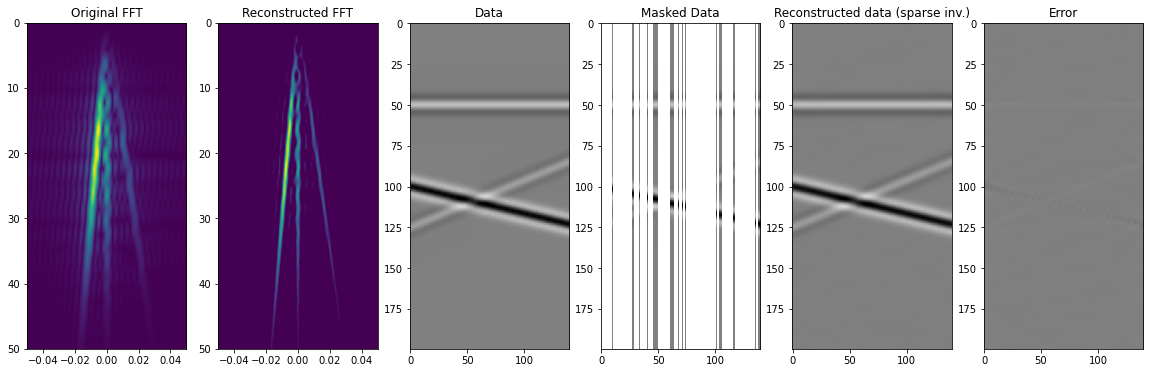

In [7]:
fig, axs = plt.subplots(1, 6, figsize=(20, 6))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.05, 0.05)
axs[1].imshow(np.fft.fftshift(np.abs(pinvf[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.05, 0.05)
axs[2].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Masked Data')
axs[3].axis('tight');
axs[4].imshow(xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight');
axs[5].imshow(x.T-xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[5].set_title('Error')
axs[5].axis('tight');

In [8]:
%%time
# Inverse with cupy
xinvf, pinvf, cost = SeismicInterpolation(cp.asarray(y), par['nx'], iava, kind='fk', nffts=(nfft, nfft), 
                                          sampling=(par['dx'], par['dt']), dottest=False,
                                          **dict(niter=50, eigsdict=dict(niter=10), eps=1e-2, show=True))

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 11200 rows and 1048576 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 50
alpha = 1.000000e+00	thresh = 5.000000e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -0.00e+00+0.00e+00j    3.112e+00   1.191e+02   3.080e+01
     2   -0.00e+00+0.00e+00j    2.955e+00   1.142e+02   1.590e+00
     3   -0.00e+00+0.00e+00j    2.781e+00   1.087e+02   1.896e+00
     4   -0.00e+00+0.00e+00j    2.599e+00   1.029e+02   2.134e+00
     5   -0.00e+00+0.00e+00j    2.422e+00   9.715e+01   2.318e+00
     6   -0.00e+00+0.00e+00j    2.253e+00   9.150e+01   2.457e+00
     7   -0.00e+00+0.00e+00j    2.097e+00   8.607e+01   2.559e+00
     8   -0.00e+00+0.00e+00j    1.951e+00   8.095e+01   2.627e+00
     9   -0.00e+00+0.00e+00j    1.819e+00   7.616e+01   2.668e+00
    10   -0.0

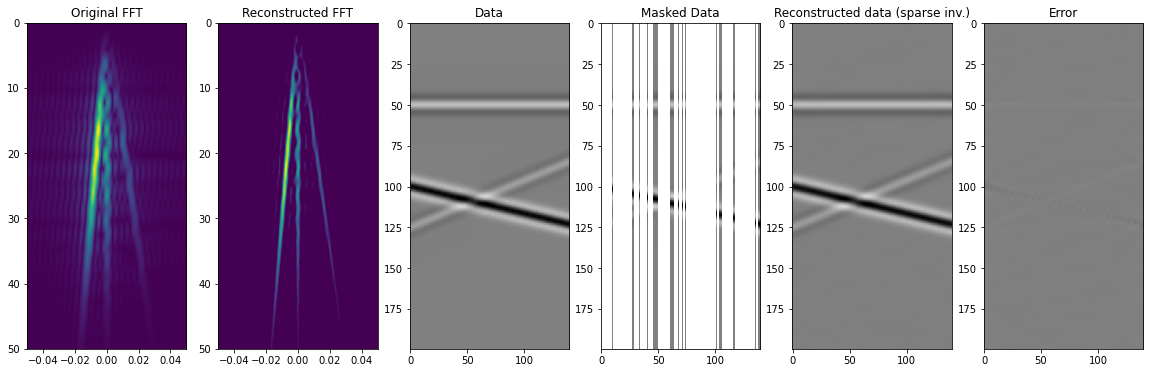

In [9]:
fig, axs = plt.subplots(1, 6, figsize=(20, 6))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.05, 0.05)
axs[1].imshow(np.fft.fftshift(np.abs(cp.asnumpy(pinvf)[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.05, 0.05)
axs[2].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Masked Data')
axs[3].axis('tight');
axs[4].imshow(cp.asnumpy(xinvf).T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight');
axs[5].imshow(x.T-cp.asnumpy(xinvf).T, cmap='gray', vmin=-2, vmax=2)
axs[5].set_title('Error')
axs[5].axis('tight');

Dot test passed, v^H(Opu)=371.12803001570603 - u^H(Op^Hv)=371.1280300157044


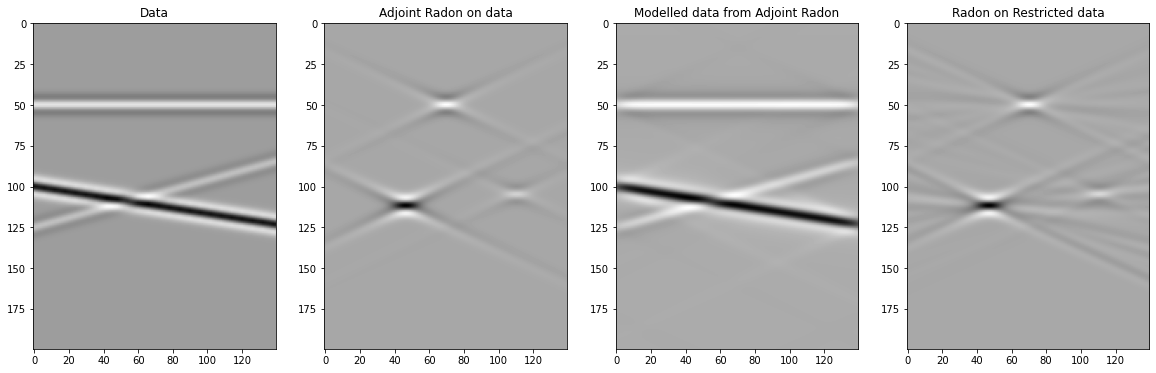

In [10]:
npx = par['nx']
pxmax = 1e-3
px = np.linspace(-pxmax, pxmax, npx)
Radop = ChirpRadon2D(taxis, xaxis, pxmax * par['dx'] / par['dt'])
dottest(Radop, par['nx']*par['nt'], npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray')
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj.T, cmap='gray')
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj.T, cmap='gray')
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj.T, cmap='gray')
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 11200 rows and 28000 cols
eps = 5.000000e-01	tol = 1.000000e-10	niter = 20
alpha = 1.313930e-04	thresh = 3.284825e-05
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -0.0000e+00         4.373e+02   4.406e+02   1.170e-01
     2       0.0000e+00         3.593e+02   3.656e+02   1.032e-01
     3       0.0000e+00         2.816e+02   2.911e+02   1.174e-01
     4       0.0000e+00         2.113e+02   2.240e+02   1.244e-01
     5       0.0000e+00         1.523e+02   1.683e+02   1.255e-01
     6       0.0000e+00         1.060e+02   1.249e+02   1.218e-01
     7       0.0000e+00         7.151e+01   9.302e+01   1.147e-01
     8       0.0000e+00         4.716e+01   7.087e+01   1.052e-01
     9       0.0000e+00         3.072e+01   5.621e+01   9.448e-02
    10       0.

(-0.5, 139.5, 199.5, -0.5)

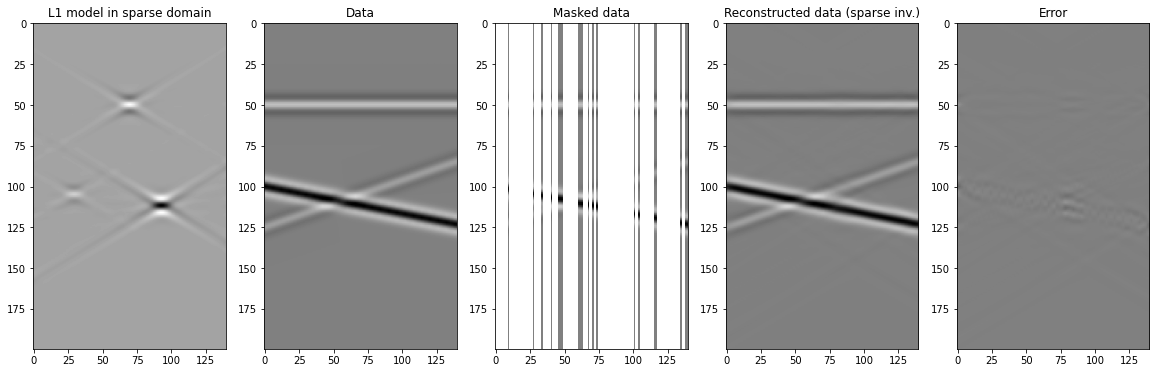

In [11]:
%%time
# numpy
px = np.linspace(-pxmax, pxmax, npx)
xinvf, pinvf, cost = SeismicInterpolation(y, par['nx'], iava, kind='radon-linear', spataxis=xaxis, 
                                          taxis=taxis, paxis=px, centeredh=True, dottest=False,
                                          **dict(niter=20, eps=5e-1, show=True))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(pinvf.T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 11200 rows and 28000 cols
eps = 5.000000e-01	tol = 1.000000e-10	niter = 20
alpha = 1.275513e-04	thresh = 3.188783e-05
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -0.0000e+00         4.354e+02   4.387e+02   1.164e-01
     2       0.0000e+00         3.560e+02   3.623e+02   1.026e-01
     3       0.0000e+00         2.771e+02   2.865e+02   1.167e-01
     4       0.0000e+00         2.060e+02   2.186e+02   1.234e-01
     5       0.0000e+00         1.467e+02   1.625e+02   1.242e-01
     6       0.0000e+00         1.006e+02   1.193e+02   1.201e-01
     7       0.0000e+00         6.664e+01   8.790e+01   1.126e-01
     8       0.0000e+00         4.305e+01   6.646e+01   1.027e-01
     9       0.0000e+00         2.746e+01   5.257e+01   9.153e-02
    10       0.

(-0.5, 139.5, 199.5, -0.5)

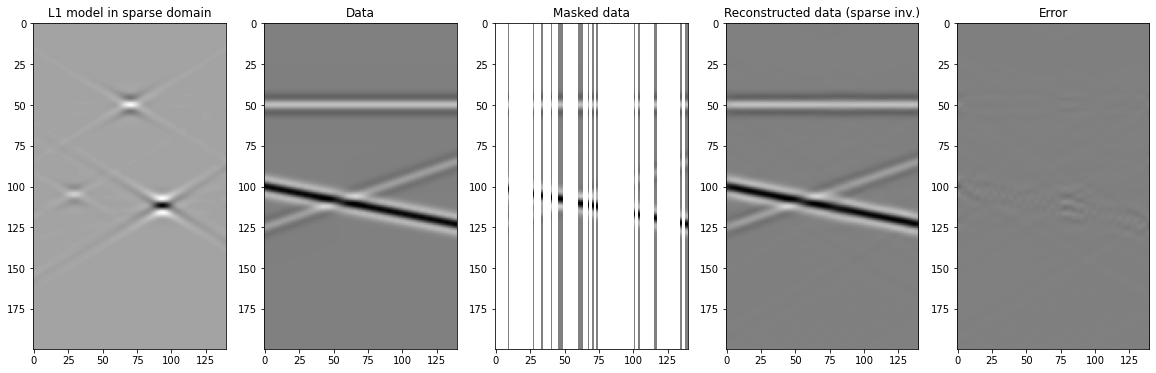

In [12]:
%%time
# cupy
px = np.linspace(-pxmax, pxmax, npx)
xinvf, pinvf, cost = SeismicInterpolation(cp.asarray(y), par['nx'], iava, kind='chirpradon-linear', spataxis=xaxis, 
                                          taxis=taxis, paxis=px, centeredh=True, dottest=False,
                                          **dict(niter=20, eps=5e-1, show=True))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(cp.asnumpy(pinvf).T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(cp.asnumpy(xinvf).T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-cp.asnumpy(xinvf).T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

## 2D realistic

sampling 150.0
Dot test passed, v^H(Opu)=-241.915729057975 - u^H(Op^Hv)=-241.915729057975


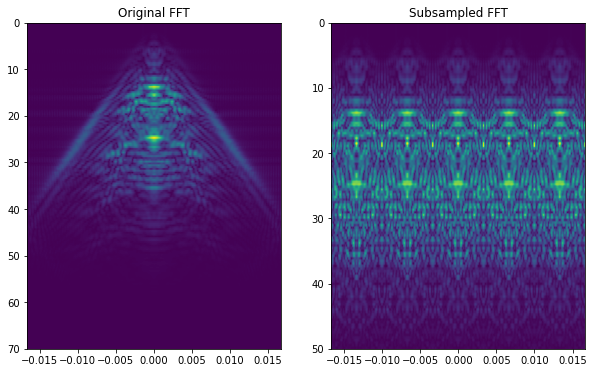

In [13]:
inputfile = '../data/marchenko/input.npz'
inputdata = np.load(inputfile)

x = inputdata['R'][50, :, :-100]
x = x/np.abs(x).max()

taxis, xaxis = inputdata['t'][:-100], inputdata['r'][0]
par = {}
par['nx'], par['nt'] = x.shape
par['dx'] = inputdata['r'][0, 1] - inputdata['r'][0, 0]
par['dt'] = inputdata['t'][1] - inputdata['t'][0]

# add wavelet
wav = 0.3*inputdata['wav']
wav_c = np.argmax(wav)
x = np.apply_along_axis(convolve, 1, x, wav, mode='full')
x = x[:, wav_c:][:, :par['nt']]

# gain
gain = np.tile((taxis**2)[:, np.newaxis], (1, par['nx'])).T
x = x*gain

# subsampling locations (random)
#perc_subsampling=0.6
#Nsub=int(np.round(par['nx']*perc_subsampling))
#iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# subsampling locations (regular)
iava = np.arange(0, par['nx'], 5)
print('sampling', par['dx']*5)
Nsub = len(iava)

# Create restriction operator
Rop = Restriction(iava=iava, dims=(par['nx'], par['nt']), axis=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

y     = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape( par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

# FFT of full data
nfft=2**10
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], sampling=[par['dx'], par['dt']])
p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft))

pmask = FFTop * ymask.flatten()
pmask = np.reshape(pmask, (nfft, nfft))

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(70, 0)
axs[1].imshow(np.fft.fftshift(np.abs(pmask[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Subsampled FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0);

Dot test passed, v^H(Opu)=-212.9664197582386 - u^H(Op^Hv)=-212.9664197582385
RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 14700 rows and 70700 cols
Regs=[<70700x70700 SecondDerivative with dtype=float64>]
epsRs=[0.31622776601683794]
-----------------------------------------------------------------
CGLS
-----------------------------------------------------------------
The Operator Op has 85400 rows and 70700 cols
damp = 1.000000e-04	tol = 1.000000e-04	niter = 200
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        0.0000e+00         4.8627e-01     4.8630e-01
     2        0.0000e+00         3.3564e-01     3.3573e-01
     3        0.0000e+00         2.6319e-01     2.6336e-01
     4        0.0000e+00         2.1967e-01     2.1993e-01
     5        0.0000e+00         1.8843e-01     1.8879e-01
     6        0.0000e+00         1.7254e-01     1.72

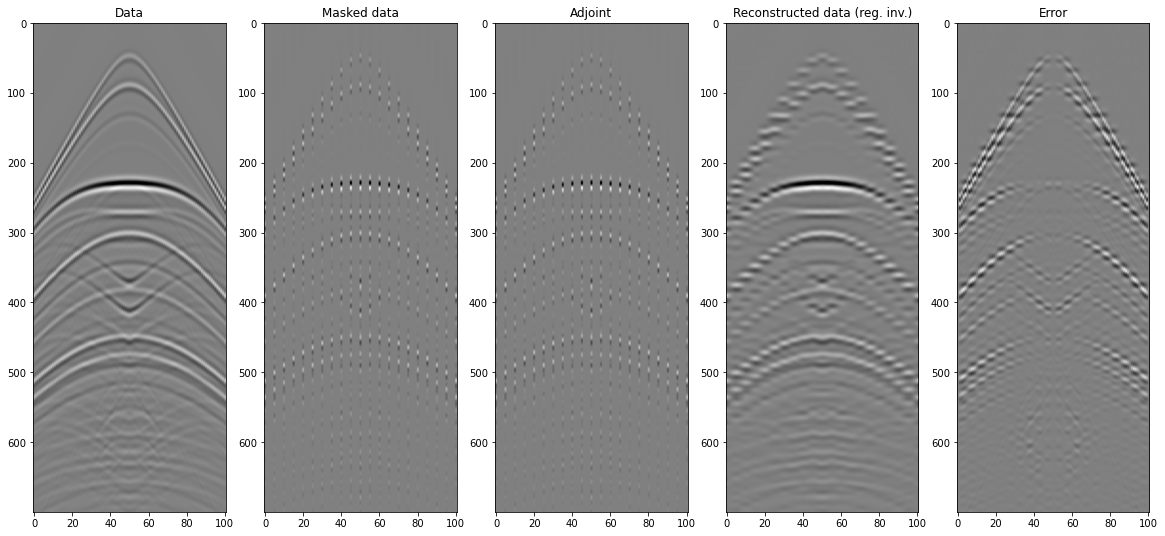

In [14]:
xinv, _, _ = SeismicInterpolation(cp.asarray(y), par['nx'], iava, kind='spatial', dottest=True,
                                  **dict(epsRs=[np.sqrt(0.1)], damp=np.sqrt(1e-4),
                                         niter=200, show=True))

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.data.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(xadj).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(cp.asnumpy(xinv).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-cp.asnumpy(xinv).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

Dot test passed, v^H(Opu)=-677.2344920543923 - u^H(Op^Hv)=-677.2344920543918
FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 14700 rows and 126000 cols
eps = 5.000000e-03	tol = 1.000000e-10	niter = 400
alpha = 1.200000e-03	thresh = 3.000000e-06
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         3.174e-01   3.202e-01   3.229e-03
     2       0.0000e+00         3.078e-01   3.133e-01   3.162e-03
     3       0.0000e+00         2.960e-01   3.048e-01   3.969e-03
     4       0.0000e+00         2.824e-01   2.952e-01   4.702e-03
     5       0.0000e+00         2.673e-01   2.847e-01   5.365e-03
     6       0.0000e+00         2.512e-01   2.735e-01   5.956e-03
     7       0.0000e+00         2.343e-01   2.621e-01   6.474e-03
     8       0.0000e+00         2.171e-01   2.507e-01   6.919e-03
  

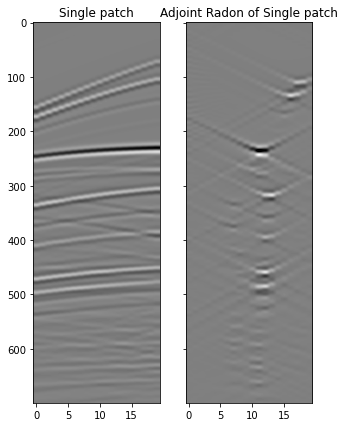

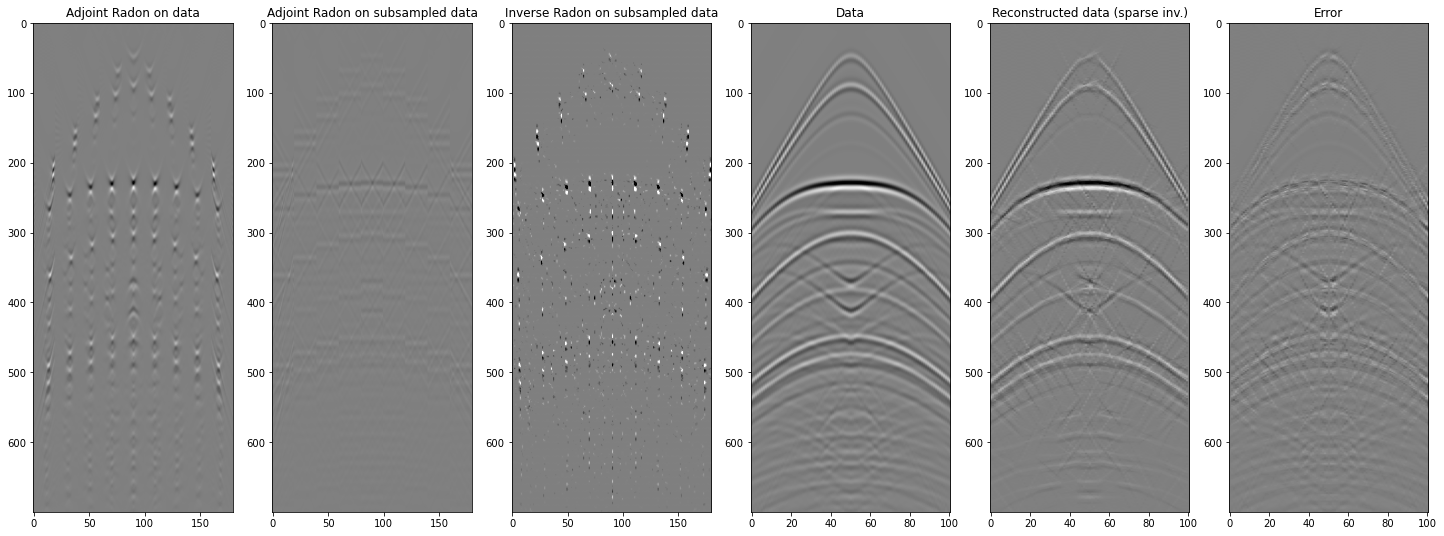

In [15]:
dx = par['dx']
nwin=20
nwins=9
nover=10
npx=nwin
pxmax = 5e-4
px = np.linspace(-pxmax, pxmax, npx)
dimsd = x.shape
dims = (nwins*npx, dimsd[1])

# sliding window radon with overlap
Op = ChirpRadon2D(taxis, np.linspace(-dx*nwin//2, dx*nwin//2, nwin), pxmax * par['dx'] / par['dt'])
Slidop = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine')
dottest(Slidop, np.prod(dimsd), np.prod(dims))

# radon on one patch
x1 = x[1*nwin:2*nwin]
y1 = Op.H*x1.flatten()
y1 = y1.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(5, 7))
axs[0].imshow(x1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].axis('tight')
axs[0].set_title('Single patch')

axs[1].imshow(y1.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[1].axis('tight')
axs[1].set_title('Adjoint Radon of Single patch');

# adjoint
Rop1 = Rop*Slidop

padj_fromx = Slidop.H*x.flatten()
padj_fromx = padj_fromx.reshape(npx*nwins, par['nt'])

padj = Rop1.H*y.flatten()
padj = padj.reshape(npx*nwins, par['nt'])

# inverse
xinv, pinv, _ = SeismicInterpolation(cp.asarray(y), par['nx'], iava, kind='chirp-sliding', spataxis=xaxis, 
                                     taxis=taxis, paxis=px, nwins=nwins, nwin=nwin, 
                                     nover=nover, dottest=True,
                                     **dict(niter=400, eps=5e-3, alpha=1.2e-3, 
                                            show=True))

fig, axs = plt.subplots(1, 6, figsize=(25, 9))
axs[0].imshow(padj_fromx.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[0].set_title('Adjoint Radon on data')
axs[0].axis('tight')
axs[1].imshow(padj.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[1].set_title('Adjoint Radon on subsampled data')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(pinv).T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[2].set_title('Inverse Radon on subsampled data')
axs[2].axis('tight')
axs[3].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Data')
axs[3].axis('tight');
axs[4].imshow(cp.asnumpy(xinv).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight')
axs[5].imshow(x.T-cp.asnumpy(xinv).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[5].set_title('Error')
axs[5].axis('tight');

## 3D

In [16]:
###### Input parameters
par = {'oy':0,'dy':2,    'ny':51,
       'ox':0,'dx':2,    'nx':30,
       'ot':0,'dt':0.004,'nt':100,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.1, 0.2, 0.3]
theta_m = [0, 30, -60]
phi_m   = [0, 50, 30]
amp_m   = [1., -2, 0.5]

# Create axis
taxis, taxis2, xaxis, yaxis = makeaxis(par)
dt, dx, dy = par['dt'], par['dx'], par['dy']

# Create wavelet
wav = ricker(taxis[:41], f0=par['f0'])[0]

# Generate model
m, x =  linear3d(xaxis, yaxis, taxis, v, t0_m, theta_m, phi_m, amp_m, wav)

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(par['ny']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['ny']))[:Nsub])

# Create restriction operator
Rop = Restriction(iava=iava, dims=(par['ny'], par['nx'], par['nt']), axis=0, dtype='float64')
dottest(Rop,Nsub*par['nx']*par['nt'], par['ny']*par['nx']*par['nt'], verb=True)

y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nx'], par['nt'])
xadj = xadj.reshape( par['ny'], par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^H(Opu)=-190.41871049085358 - u^H(Op^Hv)=-190.41871049085336


Dot test passed, v^H(Opu)=56.56454019036701 - u^H(Op^Hv)=56.564540190367104
(153000,) <213000x153000 VStack with dtype=float64>


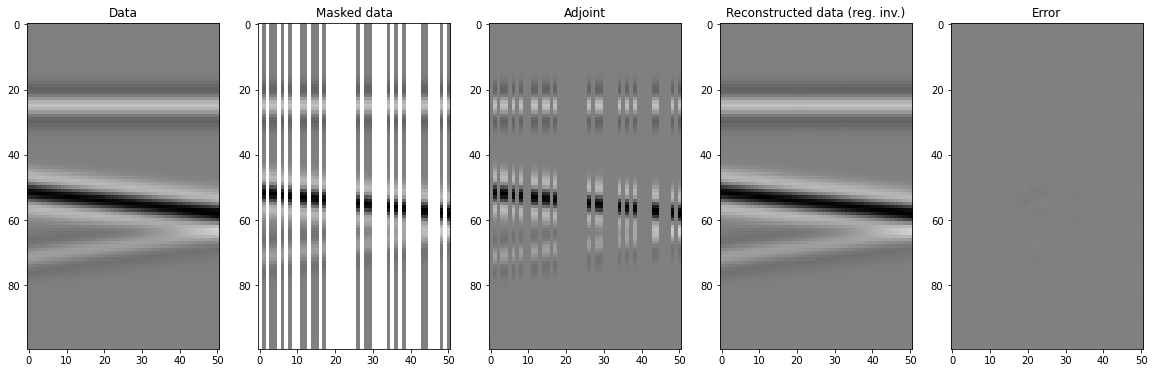

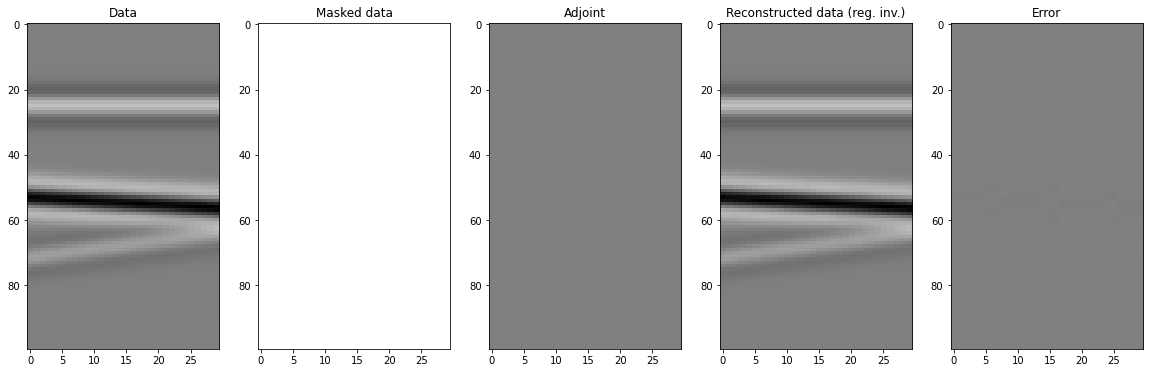

In [17]:
# Invert for interpolated signal with spatial (cupy)
xinv, _, _ = SeismicInterpolation(cp.asarray(y), (par['ny'], par['nx']), iava, kind='spatial', dottest=True,
                                  **dict(epsRs=[np.sqrt(0.1)], damp=np.sqrt(1e-4), niter=100, show=0))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(cp.asnumpy(xinv)[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x[:, par['nx']//2].T-cp.asnumpy(xinv)[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(cp.asnumpy(xinv)[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x[par['ny']//2].T-cp.asnumpy(xinv)[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

Dot test passed, v^H(Opu)=(-486.4956478918019+30.988799902759496j) - u^H(Op^Hv)=(-486.49564789180266+30.98879990275903j)
FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 60000 rows and 2097152 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 50
alpha = 1.000000e+00	thresh = 5.000000e-02
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    1.349e+02   1.701e+03   9.695e+01
     2   0.00e+00+0.00e+00j    9.823e+01   1.547e+03   9.501e+00
     3   0.00e+00+0.00e+00j    7.652e+01   1.432e+03   9.179e+00
     4   -0.00e+00+0.00e+00j    6.309e+01   1.338e+03   9.002e+00
     5   -0.00e+00+0.00e+00j    5.412e+01   1.259e+03   8.870e+00
     6   -0.00e+00+0.00e+00j    4.783e+01   1.191e+03   8.780e+00
     7   -0.00e+00+0.00e+00j    4.320e+01   1.131e+03   8.710e+00
     8   -0.00e+00+0.00e+00

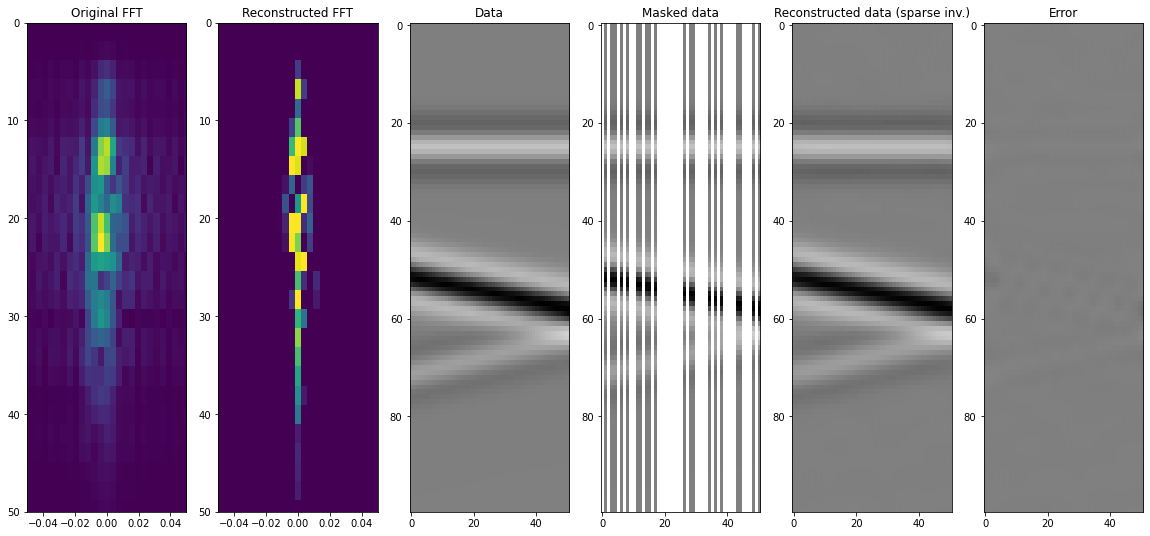

In [18]:
# Invert for interpolated signal with FK (cupy)
nfft=2**7
FFTop = FFTND(dims=[par['ny'], par['nx'], par['nt']], nffts=[nfft, nfft, nfft], 
              sampling=[par['dy'], par['dx'], par['dt']])
dottest(FFTop, nfft*nfft*nfft, par['ny']*par['nx']*par['nt'], complexflag=2, verb=True)
p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft, nfft))

# Inverse
xinv, pinv, _ = SeismicInterpolation(cp.asarray(y), (par['ny'], par['nx']), iava, 
                                     kind='fk', nffts=(nfft, nfft, nfft), 
                                     sampling=(par['dy'], par['dx'], par['dt']), dottest=False,
                                     **dict(niter=50, eps=1e-1, alpha=1e0, show=True))

fig, axs = plt.subplots(1, 6, figsize=(20, 9))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, 1, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]), vmin=0, vmax=10)
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.05, 0.05)
axs[1].imshow(np.fft.fftshift(np.abs(cp.asnumpy(pinv)[:, 1, :nfft//2-1]), axes=0).T,
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]), vmin=0, vmax=10)
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.05, 0.05)
axs[2].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Masked data')
axs[3].axis('tight')
axs[4].imshow(cp.asnumpy(xinv)[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight');
axs[5].imshow(x[:, par['nx']//2].T-cp.asnumpy(xinv)[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[5].set_title('Error')
axs[5].axis('tight');

Dot test passed, v^H(Opu)=6569.999235824611 - u^H(Op^Hv)=6569.999235824638


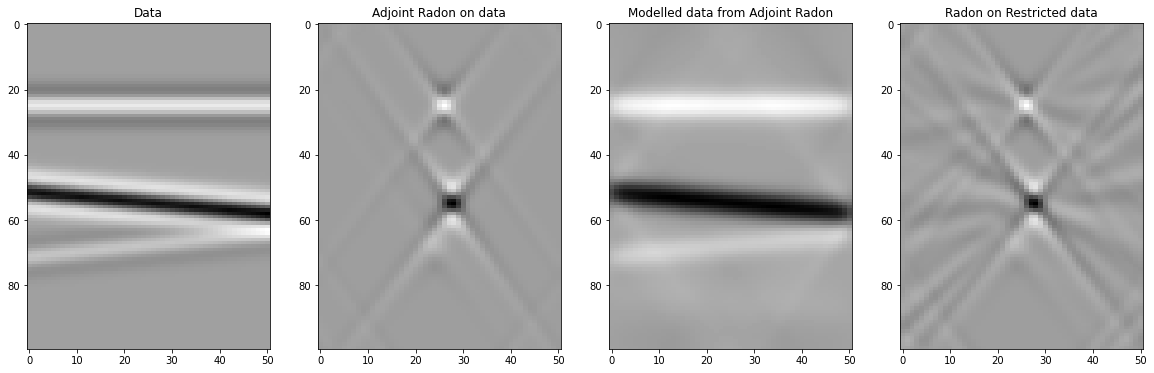

In [19]:
# Invert for interpolated signal with slidingRadon (cupy)
npy, pymax = par['ny'], 4e-3
npx, pxmax = par['nx'], 4e-3

py = np.linspace(-pymax, pymax, npy)
px = np.linspace(-pxmax, pxmax, npx)

Radop = ChirpRadon3D(taxis, yaxis, xaxis, (pymax*dy/dt, pxmax*dx/dt), dtype='float64')
dottest(Radop, par['ny']*par['nx']*par['nt'], npy*npx*par['nt'], verb=True)

Rop1 = Rop*Radop.H

# Radon on original data
xradadj = Radop * x.flatten()
yradadj = Radop.H * xradadj.flatten()

# Adjoint
xadj = Rop1.H*y.flatten()

xradadj = xradadj.reshape(par['ny'], par['nx'], par['nt'])
yradadj = yradadj.reshape(par['ny'], par['nx'], par['nt'])
xadj = xadj.reshape(par['ny'], par['nx'], par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(x[:, par['nx']//2].T, cmap='gray')
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj[:, npx//2].T, cmap='gray')
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj[:, par['nx']//2].T, cmap='gray')
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight')
axs[3].imshow(xadj[:, par['nx']//2].T, cmap='gray')
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 60000 rows and 153000 cols
eps = 5.000000e+00	tol = 1.000000e-10	niter = 400
alpha = 1.089325e-06	thresh = 2.723312e-06
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -0.0000e+00         5.607e+03   5.615e+03   1.118e-02
     2      -0.0000e+00         5.495e+03   5.510e+03   1.094e-02
     3      -0.0000e+00         5.356e+03   5.381e+03   1.375e-02
     4      -0.0000e+00         5.196e+03   5.232e+03   1.632e-02
     5      -0.0000e+00         5.018e+03   5.066e+03   1.870e-02
     6      -0.0000e+00         4.825e+03   4.887e+03   2.088e-02
     7      -0.0000e+00         4.620e+03   4.697e+03   2.289e-02
     8      -0.0000e+00         4.407e+03   4.500e+03   2.471e-02
     9       0.0000e+00         4.188e+03   4.298e+03   2.637e-02
    10       

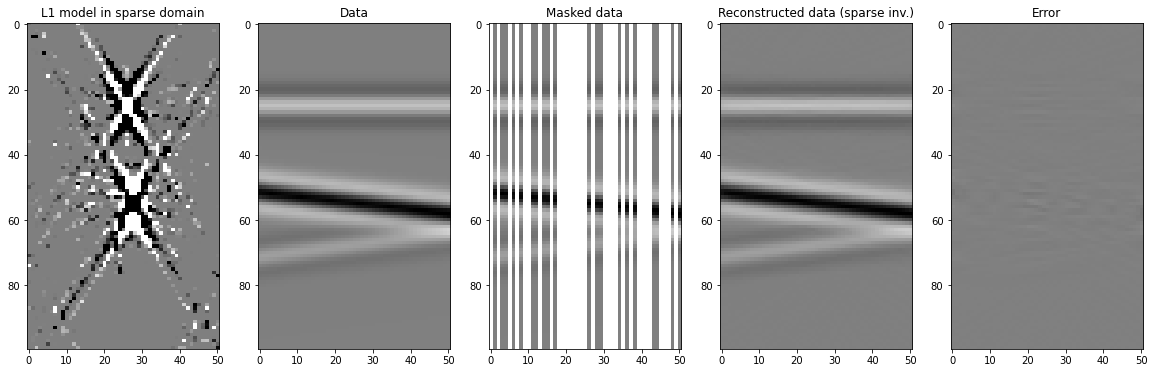

In [20]:
xinv, pinv, _ = SeismicInterpolation(cp.asarray(y), (par['ny'], par['nx']), 
                                     iava, kind='chirpradon-linear', spataxis=yaxis, spat1axis=xaxis,
                                     taxis=taxis, paxis=px, p1axis=px, centeredh=True, dottest=False,
                                     **dict(niter=400, eps=5e0, eigsdict=dict(niter=5), show=True))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(cp.asnumpy(pinv)[:, npx//2].T, cmap='gray', vmin=-0.001, vmax=0.001)
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(cp.asnumpy(xinv)[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x[:, par['nx']//2].T-cp.asnumpy(xinv)[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

## 3D Realistic

In [21]:
inputfile3d = '../data/seismicinterpolation/input3d.npz'
inputdata3d = np.load(inputfile3d)

x = np.transpose(inputdata3d['data'], (2, 1, 0))[:,:, :400:2]
x = x/np.abs(x).max()

taxis, xaxis, yaxis = inputdata3d['t'][:400:2], inputdata3d['rx'][:], inputdata3d['ry'][:]
par = {}
par['ny'], par['nx'], par['nt'] = x.shape
par['dx'] = inputdata3d['rx'][1] - inputdata3d['rx'][0]
par['dy'] = inputdata3d['ry'][1] - inputdata3d['ry'][0]
par['dt'] = inputdata3d['t'][1] - inputdata3d['t'][0]

# add wavelet
wav3d = wav[::3]
wav3d_c = np.argmax(wav3d)
x = np.apply_along_axis(convolve, 2, x, wav3d, mode='full')
x = x[:, :, wav3d_c:][:, :, :par['nt']]

# gain
gain = np.transpose(np.tile((taxis**2)[:, np.newaxis, np.newaxis], (1, par['ny'], par['nx'])), (1, 2, 0))
x = x*gain

# subsampling locations
perc_subsampling=0.6
Nsub=int(np.round(par['ny']*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(par['ny']))[:Nsub])
#iava = np.arange(0, par['ny'], 5)
#Nsub = len(iava)

# Create restriction operator
Rop = Restriction(iava=iava, dims=(par['ny'], par['nx'], par['nt']), axis=0, dtype='float64')
dottest(Rop,Nsub*par['nx']*par['nt'], par['ny']*par['nx']*par['nt'], verb=True)

y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nx'], par['nt'])
xadj = xadj.reshape( par['ny'], par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^H(Opu)=-1095.9699240532823 - u^H(Op^Hv)=-1095.9699240532782


In [22]:
dy = par['dy']
dx = par['dx']
nwin=(21, 19)
nwins=(9, 6)
nover=(9, 7)
npy=nwin[0]
npx=nwin[1]
pxmax = 5e-4
py = px = np.linspace(-pxmax, pxmax, npx)
dimsd = (par['ny'], par['nx'], par['nt'])
dims = (nwins[0]*npy, nwins[1]*npx, dimsd[2])

# sliding window radon with overlap
Op = ChirpRadon3D(taxis, np.linspace(-dy*nwin[0]//2, dy*nwin[0]//2, nwin[0]), 
                  np.linspace(-dx*nwin[1]//2, dx*nwin[1]//2, nwin[1]), 
                  (pxmax * dy /par['dt'], pxmax * dx /par['dt']))
Slidop = Sliding3D(Op, dims, dimsd, nwin, nover, (npy, npx), tapertype='cosine')
dottest(Slidop, np.prod(dimsd), np.prod(dims), verb=True)

# adjoint
Rop1 = Rop*Slidop

padj_fromx = Slidop.H*x.flatten()
padj_fromx = padj_fromx.reshape(nwins[0], nwins[1], npy, npx, par['nt'])

padj = Rop1.H*y.flatten()
padj = padj.reshape(nwins[0], nwins[1], npy, npx, par['nt'])

Dot test passed, v^H(Opu)=22227.256397205496 - u^H(Op^Hv)=22227.256397205423


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 1182600 rows and 4309200 cols
eps = 5.000000e-02	tol = 1.000000e-10	niter = 300
alpha = 2.615814e-05	thresh = 6.539534e-07
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         3.282e+00   3.296e+00   1.194e-03
     2       0.0000e+00         3.223e+00   3.251e+00   1.174e-03
     3       0.0000e+00         3.150e+00   3.195e+00   1.479e-03
     4       0.0000e+00         3.064e+00   3.131e+00   1.761e-03
     5       0.0000e+00         2.969e+00   3.059e+00   2.021e-03
     6       0.0000e+00         2.865e+00   2.981e+00   2.261e-03
     7       0.0000e+00         2.754e+00   2.899e+00   2.479e-03
     8       0.0000e+00         2.639e+00   2.814e+00   2.677e-03
     9       0.0000e+00         2.520e+00   2.728e+00   2.854e-03
    10    

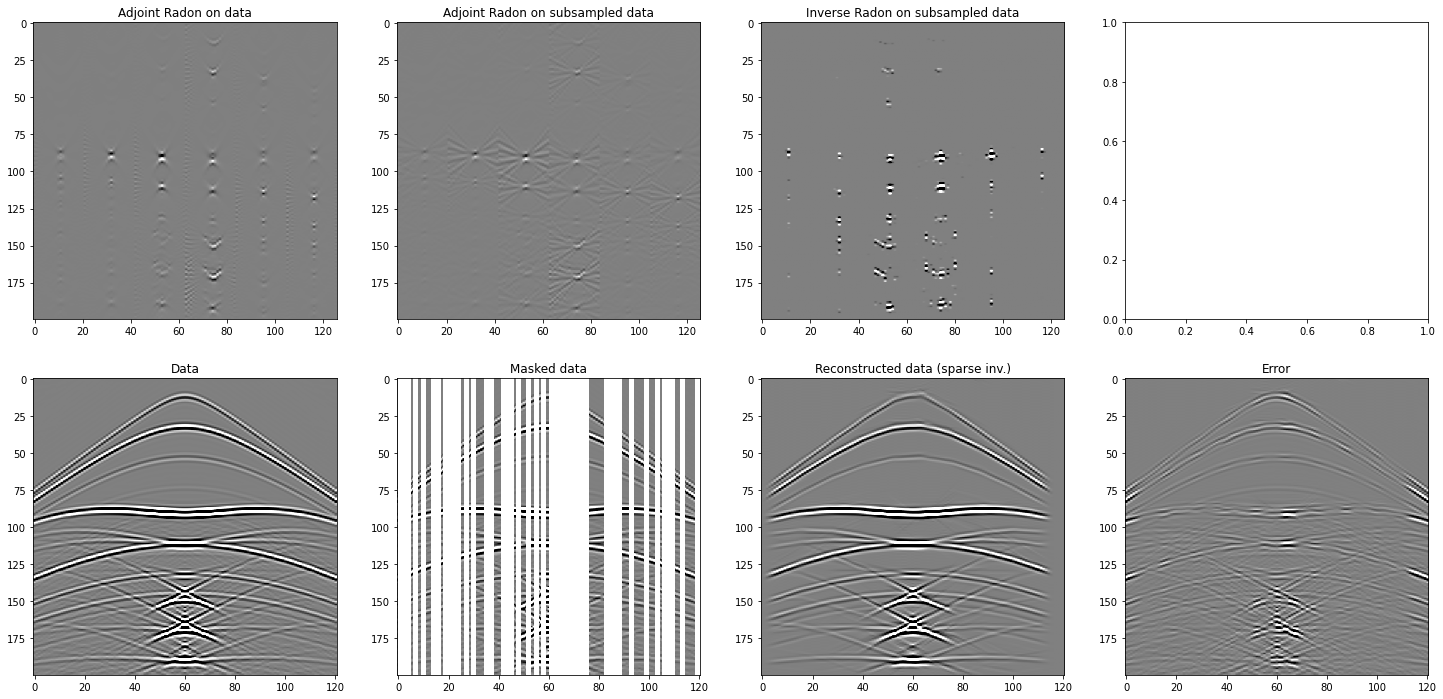

In [23]:
xinv, pinv, cost = SeismicInterpolation(cp.asarray(y), (par['ny'], par['nx']), iava, kind='chirp-sliding', 
                                        spataxis=yaxis, spat1axis=xaxis, 
                                        taxis=taxis, paxis=py, p1axis=px, nwins=nwins, nwin=nwin,
                                        nover=nover, dottest=False,
                                        **dict(niter=300, eigsdict=dict(niter=5),
                                               eps=5e-2, show=True))

fig, axs = plt.subplots(2, 4, figsize=(25, 12))
axs[0][0].imshow(padj_fromx[nwins[0]//2, :, :, npx//2].reshape(nwins[1]*npy, par['nt']).T, 
                 cmap='gray', vmin=-1, vmax=1)
axs[0][0].set_title('Adjoint Radon on data')
axs[0][0].axis('tight')
axs[0][1].imshow(padj[nwins[0]//2, :, :, npx//2].reshape(nwins[1]*npy, par['nt']).T, 
                 cmap='gray', vmin=-1, vmax=1)
axs[0][1].set_title('Adjoint Radon on subsampled data')
axs[0][1].axis('tight')
axs[0][2].imshow(cp.asnumpy(pinv)[nwins[0]//2, :, :, npx//2].reshape(nwins[1]*npy, par['nt']).T, 
                 cmap='gray', vmin=-0.001, vmax=0.001)
axs[0][2].set_title('Inverse Radon on subsampled data')
axs[0][2].axis('tight')
axs[1][0].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][0].set_title('Data')
axs[1][0].axis('tight');
axs[1][1].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][1].set_title('Masked data')
axs[1][1].axis('tight');
axs[1][2].imshow(cp.asnumpy(xinv)[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][2].set_title('Reconstructed data (sparse inv.)')
axs[1][2].axis('tight')
axs[1][3].imshow(x[:, par['nx']//2].T-cp.asnumpy(xinv)[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][3].set_title('Error')
axs[1][3].axis('tight');